# Synthesizer

In this notebook we assess the signal quality of the direct digital synthesizer (DDS).

In [1]:
import os
import control
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

duration = 26.84e-3
delays = np.linspace(0, duration, 300)

os.makedirs('../dataset/synthesizer', exist_ok=True)

scope = control.MSOX6004A('172.22.22.30')
fngen = control.FG33250A2('172.22.22.36')

scope.holla(), fngen.holla()

('AGILENT TECHNOLOGIES,MSO-X 4054A,MY57310545,07.20.2017102615\n',
 'Agilent Technologies,33220A,MY43003480,1.05-1.05-22-1\n')

In [10]:
import warnings

warnings.filterwarnings('ignore')

## Measurement

Insert the external trigger signal to the back of the Agilent 33220A function generator and connect its output with the external trigger input of the oscilloscope. Let the oscilloscope trigger on falling edge and set the time scale to 20 us. The function generator should be configured to output pulse signals with period of 30 ms. Now connect the channel 1 input of the oscilloscope with the output of the horizontal DDS. Check that the DDS driver server is configured to have the sinc filter turned off.

In [8]:
control.aod_h(frequency=[80e6, 120e6], amplitude=np.ones(1024), duration=duration)

data = []

for t in delays:
    fngen.width(t)
    
    data.append((t, scope.capture()))

for (t, df) in data:
    df.to_hdf('../dataset/synthesizer/horizontal-sinc-off.h5', str(t), format='table', complevel=9)

<Response [204]>

Restart the DDS driver server with sinc filter turned on and repeat measurements for this configuration by executing the next cell.

In [11]:
control.aod_h(frequency=[80e6, 120e6], amplitude=np.ones(1024), duration=duration)

data = []

for t in delays:
    fngen.width(t)
    
    data.append((t, scope.capture()))

for (t, df) in data:
    df.to_hdf('../dataset/synthesizer/horizontal-sinc-on.h5', str(t), format='table', complevel=9)

Now connect the vertical DDS with the oscillscope output. Check again that the DDS driver has the inverse sinc filter turned off.

In [12]:
control.aod_v(frequency=[80e6, 120e6], amplitude=np.ones(1024), duration=duration)

data = []

for t in delays:
    fngen.width(t)
    
    data.append((t, scope.capture()))

for (t, df) in data:
    df.to_hdf('../dataset/synthesizer/vertical-sinc-off.h5', str(t), format='table', complevel=9)

As before restart the DDS driver with inverse sinc filter turned on.

In [13]:
control.aod_v(frequency=[80e6, 120e6], amplitude=np.ones(1024), duration=duration)

data = []

for t in delays:
    fngen.width(t)
    
    data.append((t, scope.capture()))

for (t, df) in data:
    df.to_hdf('../dataset/synthesizer/vertical-sinc-on.h5', str(t), format='table', complevel=9)

## Evaluation

We are interested in the signal amplitude in dependence of the frequency. Thus we will do a FFT on each segment to identify the dominant frequency and take the maximum voltage as amplitude. Then we compare the different configuration.

In [45]:
def fft(df):
    T = df.time.values[1] - df.time.values[0]
    N = df.voltage.size
    
    A = np.abs(np.fft.fft(df.voltage)) / N
    f = np.linspace(0, 1/T, N)

    return f[:N // 2], A[:N // 2]

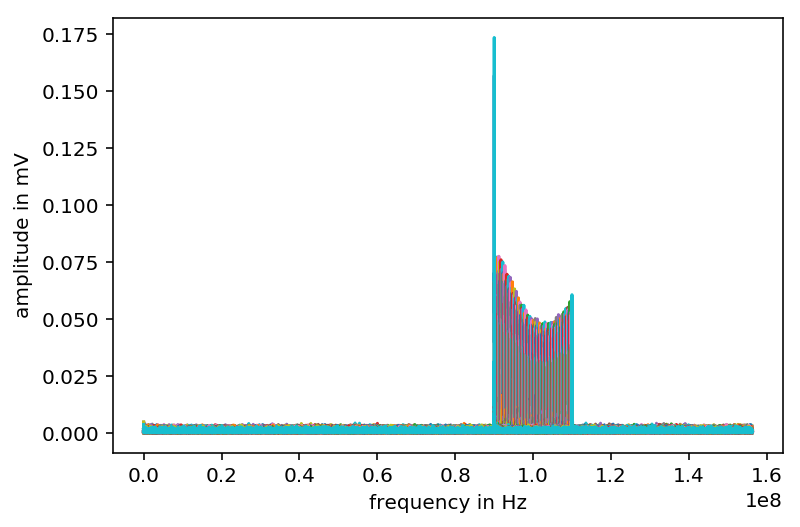

In [47]:
for df in data:
    x, y = fft(df)

    plt.plot(x, y)
    
plt.xlabel('frequency in Hz')
plt.ylabel('amplitude in mV')
plt.show()

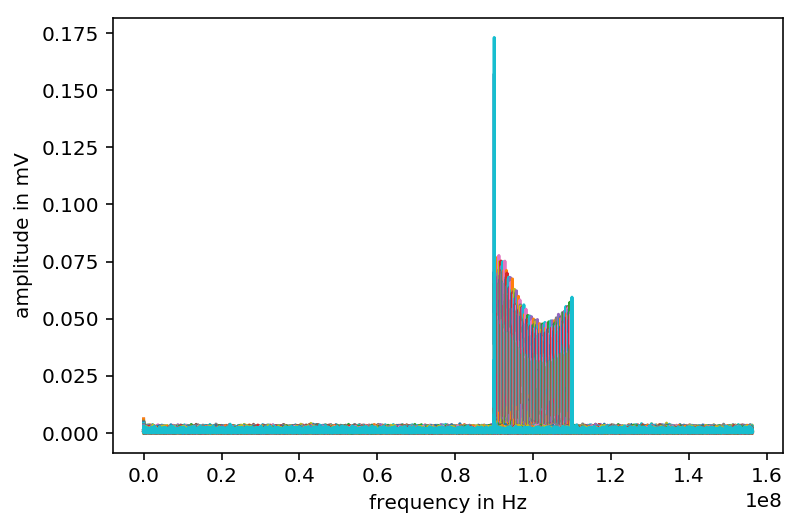

In [80]:
for df in data3:
    x, y = fft(df)

    plt.plot(x, y)
    
plt.xlabel('frequency in Hz')
plt.ylabel('amplitude in mV')
plt.show()

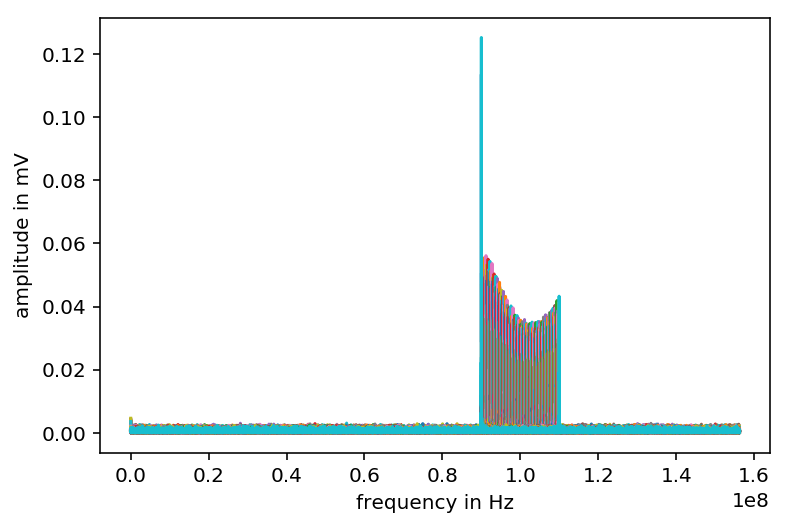

In [72]:
for df in data2:
    x, y = fft(df)

    plt.plot(x, y)
    
plt.xlabel('frequency in Hz')
plt.ylabel('amplitude in mV')
plt.show()

In [89]:
f2 = []
A2 = []

for df in data2:
    x, y = fft(df)

    i = y.argmax()
    
    A2.append(y[i])
    f2.append(x[i])

In [103]:
f3 = []
A3 = []

for t, df in data:
    x, y = fft(df)

    i = y.argmax()
    
    A2.append(y[i])
    f2.append(x[i])

## Conclusion

We find that the amplitude of the DDS has a frequency dependence. The datasheet suggests that this is an intrinsic property of direct digital synthesis and advertises an inverse sinc filter to circumvent the frequency dependence.

We find that the inverse sinc filter does not really eliminate the frequency dependence of the amplitude but decreases the overall power output, henceforth we decide to not use the inverse sinc filter in any further experiments.